# Prelim

In [27]:
!pip install signatory

!pip install pytorch-transformers

In [0]:
import logging

import pandas as pd
import numpy as np
import random
import signatory
#import iisignature
from sklearn.model_selection import train_test_split
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score
from tqdm import tqdm, trange

import torch
from torch import nn
from torch import autograd
from torch.autograd import Variable
import torch.nn.functional as F
from sklearn.model_selection import train_test_split
from torch.nn.utils.rnn import pad_sequence
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler
from torch import optim
import torchtext

#from pytorch_transformers import *
from pytorch_transformers import BertTokenizer, BertConfig, AdamW, WarmupLinearSchedule



In [29]:
import os
os.environ['CUDA_VISBLE_DEVICES'] = '0'
use_cude = True

import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

Found GPU at: /device:GPU:0


'Tesla K80'

In [30]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# load data

In [0]:
data = pd.read_csv(r"/content/drive/My Drive/berkeley/no-complex-oversample.txt", header = None)


In [0]:
from ast import literal_eval
sentence_list = data[0][1:].values.tolist()
sentence_list = ["[CLS] " + sentence + " [SEP]" for sentence in sentence_list]


tag = data[2][1:].values.tolist()



In [33]:
tags2vals = list(set(tag))
tag2idx = {t: i for i, t in enumerate(tags2vals)}
print(tag2idx)

{'DISONLY': 0, 'PREVENT': 1, 'NONE': 2, 'TREAT_NO_FOR_DIS': 3, 'TREAT_FOR_DIS': 4, 'TREATONLY': 5, 'VAGUE': 6, 'SIDE_EFF': 7}


# BERT

In [0]:
# load pre-trained BERT with signature method coded in 
import sys
sys.path.append('/content/drive/My Drive/transformer')
import modeling_bert43 as mb

In [35]:
tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
model = mb.BertForSequenceClassification.from_pretrained('bert-base-uncased',num_labels=8)
model.cuda()

BertForSequenceClassification(
  (bert): BertModel(
    (embeddings): BertEmbeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (token_type_embeddings): Embedding(2, 768)
      (LayerNorm): BertLayerNorm()
      (dropout): Dropout(p=0.1)
    )
    (encoder): BertEncoder(
      (layer): ModuleList(
        (0): BertLayer(
          (attention): BertAttention(
            (self): BertSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1)
            )
            (output): BertSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
              (LayerNorm): BertLayerNorm()
              (dropout): Dropout(p=0.1)
            )
          )
          (intermediat

In [36]:
tokenized_texts = [tokenizer.tokenize(sent) for sent in sentence_list]
print(tokenized_texts[0])


input_ids = [torch.tensor(tokenizer.convert_tokens_to_ids(x)) for x in tokenized_texts]

input_ids = pad_sequence(input_ids, batch_first=True).detach().numpy()

label = [tag2idx.get(l) for l in tag]

len(input_ids[0])

['[CLS]', 'all', 'live', 'births', '>', 'or', '=', '23', 'weeks', 'at', 'the', 'university', 'of', 'vermont', 'in', '1995', '(', 'n', '=', '239', '##5', ')', 'were', 'retrospective', '##ly', 'analyzed', 'for', 'delivery', 'route', ',', 'indication', 'for', 'cesare', '##an', ',', 'ge', '##station', '##al', 'age', ',', 'par', '##ity', ',', 'and', 'practice', 'group', '(', 'to', 'reflect', 'risk', 'status', ')', '.', '[SEP]']


188

In [0]:
# Create attention masks
attention_masks = []

# Create a mask of 1s for each token followed by 0s for padding
for seq in input_ids:
  seq_mask = [float(i>0) for i in seq]
  attention_masks.append(seq_mask) 

# Use train_test_split to split our data into train and validation sets for training

train_inputs, val_inputs, train_labels, val_labels = train_test_split(input_ids, label, stratify = label,
                                                            random_state=2018, test_size=0.2)

train_masks, val_masks, _, _ = train_test_split(attention_masks, input_ids, stratify = label,
                                             random_state=2018, test_size=0.2)

                                           
  
# #print(train_inputs)

# from imblearn.over_sampling import SMOTE

# smote = SMOTE('not majority', random_state=2018)
# train_masks, _ = smote.fit_resample(train_masks, train_labels)
# train_inputs, train_labels = smote.fit_resample(train_inputs, train_labels)


# print(len(train_labels))
# print(len(train_masks))

# from collections import Counter
# tr_tags = [tags2vals[p] for p in train_labels]
# Counter(tr_tags)

In [38]:
from collections import Counter
val_tags = [tags2vals[p] for p in val_labels]
Counter(val_tags)

Counter({'DISONLY': 126,
         'NONE': 364,
         'PREVENT': 13,
         'SIDE_EFF': 6,
         'TREATONLY': 34,
         'TREAT_FOR_DIS': 166,
         'TREAT_NO_FOR_DIS': 2,
         'VAGUE': 7})

In [0]:
train_inputs = torch.tensor(train_inputs)
val_inputs = torch.tensor(val_inputs)
val_labels = torch.tensor(val_labels)
train_masks = torch.tensor(train_masks)
val_masks = torch.tensor(val_masks)

In [40]:
print(train_inputs.size())
print(train_labels.size())
print(train_masks.size())

print(val_inputs.size())
print(val_labels.size())
print(val_masks.size())

torch.Size([2870, 188])
torch.Size([2870])
torch.Size([2870, 188])
torch.Size([718, 188])
torch.Size([718])
torch.Size([718, 188])


In [0]:
# Create an iterator of our data with torch DataLoader. This helps save on memory during training because, unlike a for loop, 
# with an iterator the entire dataset does not need to be loaded into memory
batch_size = 16

train_data = TensorDataset(train_inputs, train_masks, train_labels)
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)

val_data = TensorDataset(val_inputs, val_masks, val_labels)
val_sampler = SequentialSampler(val_data)
val_dataloader = DataLoader(val_data, sampler=val_sampler, batch_size=batch_size)


## train

In [0]:
param_optimizer = list(model.named_parameters())
no_decay = ['bias', 'gamma', 'beta']
optimizer_grouped_parameters = [
    {'params': [p for n, p in param_optimizer if not any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.01},
    {'params': [p for n, p in param_optimizer if any(nd in n for nd in no_decay)],
     'weight_decay_rate': 0.0}
]

In [0]:
# This variable contains all of the hyperparemeter information our training loop needs
lr = 3e-5
max_grad_norm = 1.0
num_total_steps = 1000
num_warmup_steps = 100
warmup_proportion = float(num_warmup_steps) / float(num_total_steps)  # 0.1

optimizer = AdamW(model.parameters(), lr=lr, correct_bias=False, weight_decay=5e-5)
scheduler = WarmupLinearSchedule(optimizer, warmup_steps=num_warmup_steps, t_total=num_total_steps)  # PyTorch scheduler

In [0]:
# Function to calculate the accuracy of our predictions vs labels
def flat_accuracy(preds, labels):
    pred_flat = np.argmax(preds, axis=1).flatten()
    labels_flat = labels.flatten()
    return np.sum(pred_flat == labels_flat) / len(labels_flat)

In [45]:
import tensorflow as tf

device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
n_gpu = torch.cuda.device_count()
torch.cuda.get_device_name(0)

Found GPU at: /device:GPU:0


'Tesla K80'

In [47]:
import time
start = time.time()

val_loss_tt = []
val_acc_tt = []
train_loss_tt = []
f1_score_tt=[]
precision_score_tt=[]
recall_score_tt=[]
auc_score_rr=[]

none = []
disonly = []
PREVENT = []
TREAT_FOR_DIS = []
TREAT_NO_FOR_DIS= []
VAGUE = []
SIDE_EFF = []
TREATONLY = []


CUDA_LAUNCH_BLOCKING=1 
train_loss_set = []

# Number of training epochs (authors recommend between 2 and 4)
epochs = 3

# trange is a tqdm wrapper around the normal python range
for _ in trange(epochs, desc="Epoch"):
  
  
  # Training
  
  # Set our model to training mode (as opposed to evaluation mode)
  model.train()
  
  # Tracking variables
  tr_loss = 0
  nb_tr_examples, nb_tr_steps = 0, 0
  
  # Train the data for one epoch
  for step, batch in enumerate(train_dataloader):
    # Add batch to GPU
    batch = tuple(t for t in batch)
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch

    b_labels = b_labels.unsqueeze(-1)
    
    
    b_input_ids = b_input_ids.cuda()
    b_input_mask = b_input_mask.cuda()
    b_labels = b_labels.cuda()
    
    
    # Clear out the gradients (by default they accumulate)
    optimizer.zero_grad()
    
    # Forward pass

    outputs = model(input_ids=b_input_ids, attention_mask=b_input_mask, labels=b_labels)
  
    #print(outputs)
    loss, logits = outputs[:2]
    train_loss_set.append(loss)  

    # Backward pass
    loss.backward()
    # Update parameters and take a step using the computed gradient
    torch.nn.utils.clip_grad_norm_(model.parameters(), max_grad_norm)  # Gradient clipping is not in AdamW anymore (so you can use amp without issue)
    scheduler.step()
    optimizer.step()
    optimizer.zero_grad()
    
    
    # Update tracking variables
    tr_loss += loss
    nb_tr_examples += b_input_ids.size(0)
    nb_tr_steps += 1

  print("Train loss: {}".format(tr_loss/nb_tr_steps))
  train_loss_tt.append(tr_loss/nb_tr_steps)
    
    
  # Validation

  # Put model in evaluation mode to evaluate loss on the validation set
  model.eval()

  # Tracking variables 
  eval_loss2, eval_accuracy2 = 0, 0
  nb_eval_steps2, nb_eval_examples2 = 0, 0
  predictions , true_labels = [], []

  # Evaluate data for one epoch
  for batch in val_dataloader:
    
    # Add batch to GPU
    batch = tuple(t for t in batch)
    
    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch
    
    b_input_ids = b_input_ids.cuda()
    b_input_mask = b_input_mask.cuda()
    b_labels = b_labels.cuda()
    
    # Telling the model not to compute or store gradients, saving memory and speeding up validation
    with torch.no_grad():
      # Forward pass, calculate logit predictions
      ot = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask)
      logits = ot[0]
      outputs = model(b_input_ids, token_type_ids=None, attention_mask=b_input_mask, labels = b_labels.unsqueeze(-1))
      loss = outputs[0]
    
    # Move logits and labels to CPu
    
    m = nn.Softmax()
    pred = m(logits).to('cpu').detach().numpy()
    label_ids = b_labels.to('cpu').numpy()
    
    predictions.extend([p for p in np.argmax(pred, axis=1)])
    true_labels.append(label_ids)
    
    
    tmp_eval_accuracy = flat_accuracy(pred, label_ids)
    #print(tmp_eval_accuracy)
    
    eval_accuracy2 += tmp_eval_accuracy
    nb_eval_steps2 += 1
    eval_loss2 += loss
    

  print("Validation loss: {}".format(eval_loss2/nb_eval_steps2))
  print("Validation Accuracy: {}".format(eval_accuracy2/nb_eval_steps2))
  pred_tags = [tags2vals[p] for p in predictions]
  valid_tags = [tags2vals[l_i] for l in true_labels for l_i in l]
  
  print("F1-Score: {}".format(f1_score(valid_tags, pred_tags, average=None, labels=tags2vals)))
  print("Precision-Score: {}".format(precision_score( valid_tags, pred_tags, average=None, labels=tags2vals)))
  print("Recall-Score: {}".format(recall_score( valid_tags, pred_tags, average=None, labels=tags2vals)))
  #print("AUC-Score: {}".format(roc_auc_score( valid_tags, pred_tags, average=None)))#, labels=tags2vals)))

  f1 = f1_score(valid_tags, pred_tags, average=None, labels=tags2vals)
  precision = precision_score(valid_tags, pred_tags, average='macro', labels=tags2vals)
  recall = recall_score(valid_tags, pred_tags, average='macro', labels=tags2vals)
  #acu = roc_auc_score(valid_tags, pred_tags, average='macro')#, labels=tags2vals)


  val_loss_tt.append(eval_loss2/nb_eval_steps2)
  val_acc_tt.append(eval_accuracy2/nb_eval_steps2)
  f1_score_tt.append(sum(f1)/len(f1))
  precision_score_tt.append(precision)
  recall_score_tt.append(recall)
  #auc_score_tt.append(auc)

  none.append(f1[0])
  disonly.append(f1[1])
  PREVENT.append(f1[2])
  TREAT_FOR_DIS.append(f1[3])
  TREAT_NO_FOR_DIS.append(f1[4])
  VAGUE.append(f1[5])
  SIDE_EFF.append(f1[6])
  TREATONLY.append(f1[7])

end = time.time()
print('train time:', end - start)
 


Epoch:   0%|          | 0/3 [00:00<?, ?it/s]

Train loss: 0.6756553649902344


/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:119: UserWarning: Implicit dimension choice for softmax has been deprecated. Change the call to include dim=X as an argument.
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: F-score is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)
/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision is ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)

Epoch:  33%|███▎      | 1/3 [04:36<09:12, 276.29s/it]

Validation loss: 0.5502960085868835
Validation Accuracy: 0.8299603174603174
F1-Score: [0.79704797 0.25       0.90055249 0.         0.86350975 0.19607843
 0.         0.        ]
Precision-Score: [0.74482759 0.66666667 0.90555556 0.         0.80310881 0.29411765
 0.         0.        ]
Recall-Score: [0.85714286 0.15384615 0.8956044  0.         0.93373494 0.14705882
 0.         0.        ]
Train loss: 0.3356260061264038



Epoch:  67%|██████▋   | 2/3 [09:12<04:36, 276.24s/it]

Validation loss: 0.7678780555725098
Validation Accuracy: 0.853968253968254
F1-Score: [0.79166667 0.66666667 0.9132948  0.66666667 0.89398281 0.51515152
 0.25       0.        ]
Precision-Score: [0.7037037  0.72727273 0.96341463 1.         0.85245902 0.53125
 1.         0.        ]
Recall-Score: [0.9047619  0.61538462 0.86813187 0.5        0.93975904 0.5
 0.14285714 0.        ]
Train loss: 0.1576487421989441



Epoch: 100%|██████████| 3/3 [13:48<00:00, 276.10s/it]


Validation loss: 0.9516106843948364
Validation Accuracy: 0.8714285714285714
F1-Score: [0.83921569 0.68965517 0.93184979 1.         0.87687688 0.61333333
 0.4        0.        ]
Precision-Score: [0.82945736 0.625      0.94366197 1.         0.8742515  0.56097561
 0.375      0.        ]
Recall-Score: [0.84920635 0.76923077 0.92032967 1.         0.87951807 0.67647059
 0.42857143 0.        ]
train time: 828.1948297023773


In [48]:
tags2vals

['DISONLY',
 'PREVENT',
 'NONE',
 'TREAT_NO_FOR_DIS',
 'TREAT_FOR_DIS',
 'TREATONLY',
 'VAGUE',
 'SIDE_EFF']

Text(0.5, 0, 'epochs')

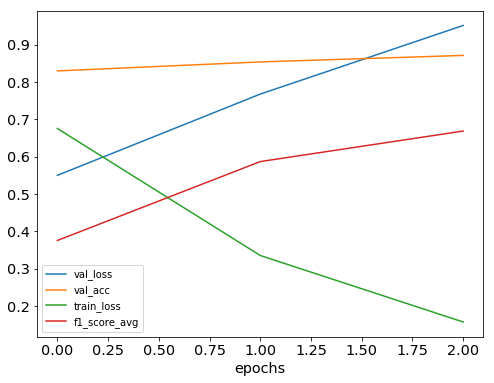

In [49]:
import matplotlib.pyplot as plt
import matplotlib.pylab as pylab
params = {'legend.fontsize': 'medium',
          'figure.figsize': (8, 6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
pylab.rcParams.update(params)

plt.plot(range(epochs), val_loss_tt, label='val_loss')
plt.plot(range(epochs), val_acc_tt, label='val_acc')
plt.plot(range(epochs), train_loss_tt, label='train_loss')
plt.plot(range(epochs), f1_score_tt, label='f1_score_avg')
plt.legend()
plt.xlabel('epochs')
#plt.savefig('/content/drive/My Drive/sig/SIG_fine_tune33.png', dpi=500)

Text(0, 0.5, 'f1 score')

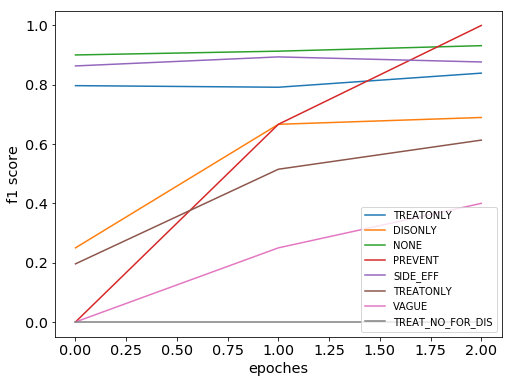

In [53]:
import matplotlib.pyplot as plt
plt.plot(range(epochs), none, label='TREATONLY')
plt.plot(range(epochs), disonly, label='DISONLY')
plt.plot(range(epochs), PREVENT, label='NONE')
plt.plot(range(epochs), TREAT_FOR_DIS, label='PREVENT')
plt.plot(range(epochs), TREAT_NO_FOR_DIS, label='SIDE_EFF')
plt.plot(range(epochs), VAGUE, label='TREATONLY')
plt.plot(range(epochs), SIDE_EFF, label='VAGUE')
plt.plot(range(epochs), TREATONLY, label='TREAT_NO_FOR_DIS')
plt.legend(loc = 'lower right')
plt.xlabel('epoches')
plt.ylabel('f1 score')
#plt.savefig('/content/drive/My Drive/sig/SIG_fine_tune3.png', dpi=500)

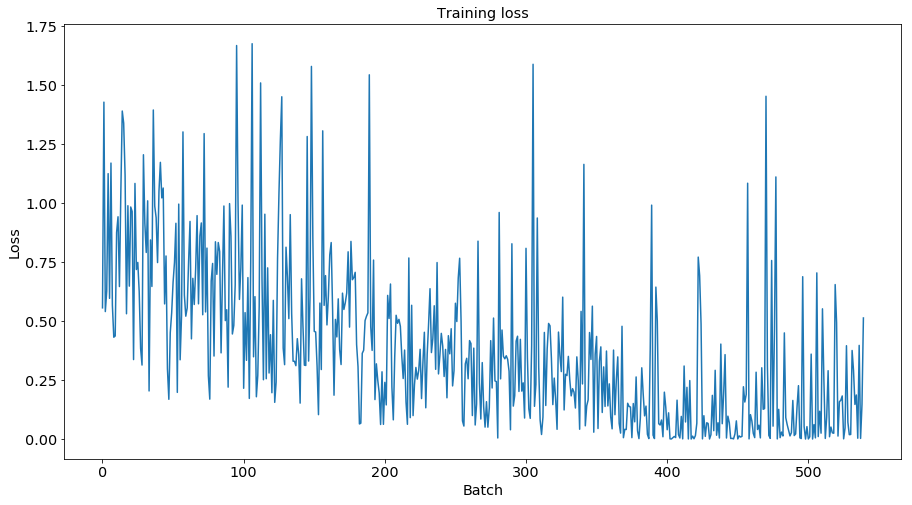

<Figure size 576x432 with 0 Axes>

In [51]:
plt.figure(figsize=(15,8))
plt.title("Training loss")
plt.xlabel("Batch")
plt.ylabel("Loss")
plt.plot(train_loss_set)
plt.show()
plt.savefig('/content/drive/My Drive/train-loss.png', dpi=1000)


In [52]:
n=-1

print('accuracy', val_acc_tt[n])
print('f1', f1_score_tt[n])
print('recall', recall_score_tt[n])
print('precision', precision_score_tt[n])

accuracy 0.8714285714285714
f1 0.6688663575344282
recall 0.6904158597328335
precision 0.6510433053667697


In [0]:
train_loss_tt[-1]